# Assignment 13 Text Analytics

In this assignment, you will:
- Load and inspect a real-world business reviews dataset.
- Preprocess review text for NLP (tokenization, stopwords, lemmatization).
- Run sentiment analysis (rule-based and classifier-based) and compare to star ratings.
- Extract main topics from reviews using LDA and (optional) BERTopic.
- Interpret results in a business context (actionable insights).

## Why This Matters

Customer Reviews are critical for the survival of any business, but especially for restaurants.  Restaurants compete with not only all of the other restaurants in local area, but also with the option for customers to stay home and cook their own food.  Chefs and restaurant owners must monitor customer feedback to see if they should make changes to their pricing, menu options, restaurant amenities and seating/serving process.

You have been given 100 customer reviews.  Your job is to look for main topics that are mentioned, and whether those reviews have a postive, neutral or negative tone (sentiment).  

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/assignment_13_text_analytics.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Original Source: Dataset Description

The dataset you'll be using is a set of **restaurant reviews**, available from [Kaggle](https://www.kaggle.com/datasets/pruthvirajgshitole/e-commerce-purchases-and-reviews?utm_source=chatgpt.com&select=customer_purchase_data.csv).

Each row represents one customer review. The columns include:

- **Review** - text of the customer review
- **Liked** - indicates if the customer likes (1) or does not like (0) the restaurant

Please note that some reviews have commas and apostrophes, which can prevent the record from loading correctly.  You should verify that you have 1,000 reviews total.  

## 1. Load and Preview the Data

### Do the following:
1. Import your TSV file called `Restaurant_Reviews.tsv`.  Note that TSV is for Tab Separated Values.  This file does not use commas as a delimiter.
2. Use `pandas` to load and preview the dataset
3. Verify that all 1,000 rows were imported correctly
4. Calculate the overall percentage of reviews that "Liked" the restaurant
5. Create a visualization to show the percentage of likes versus non-likes


In [7]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
# Load the reviews
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/refs/heads/main/DataSets/Restaurant_Reviews.tsv"
df = pd.read_csv(url, sep='\t', quoting=csv.QUOTE_MINIMAL)

df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [2]:
# Add code here 🔧
# verify row count is 1000
assert df.shape[0] == 1000, f"Expected 1000 rows but got {df.shape[0]}"


In [3]:
# show percentage liked
pct_liked = df['Liked'].mean() * 100
print(f"Percent liked: {pct_liked:.2f}%")

Percent liked: 50.00%


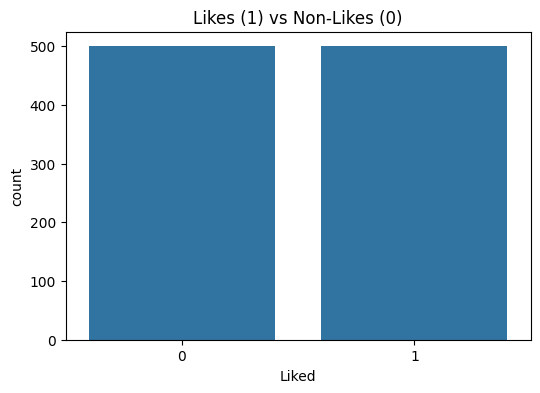

In [8]:
# quick bar plot of likes vs non-likes
plt.figure(figsize=(6,4))
sns.countplot(x='Liked', data=df)
plt.title("Likes (1) vs Non-Likes (0)")
plt.show()

## 2. Drop Columns Not Useful for Modeling

**Business framing:**  
To do text analysis, we need to remove all of the junk in the reviews.  This would include anything like punctuation, website URLs, emojis, etc.

### Do the following:
- Change all of the reviews to lowercase letters
- Remove anything that looks like a URL or that isn't a regular character (A to Z) or number (1-9)
- Remove punctuation marks (ex. !.,-:;)

### In Your Response:
1. What risks might occur if you included the review "junk" in your model?


In [10]:
import re
import string

# Add code here 🔧
# Cleaning function
def clean_review(text):
    if not isinstance(text, str):
        return ""

    # 1. lowercase
    text = text.lower()

    # 2. remove URLs
    text = re.sub(r'http\S+|www\.\S+', ' ', text)

    # 3. remove anything not A–Z or 0–9 (emojis, symbols, accents, etc.)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    # 4. remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # 5. remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning
df['clean_review'] = df['Review'].astype(str).apply(clean_review)

# View results
print(df[['Review', 'clean_review']].head())

                                              Review  \
0                           Wow... Loved this place.   
1                                 Crust is not good.   
2          Not tasty and the texture was just nasty.   
3  Stopped by during the late May bank holiday of...   
4  The selection on the menu was great and so wer...   

                                        clean_review  
0                               wow loved this place  
1                                  crust is not good  
2           not tasty and the texture was just nasty  
3  stopped by during the late may bank holiday of...  
4  the selection on the menu was great and so wer...  


### ✍️ Your Response: 🔧
1. Random symbols, URLs, emojis, punctuation, and weird characters inflate the vocabulary with meaningless tokens, making it harder for the model to learn actual patterns. Extra punctuation like “!!!!!!!” can mislead rule-based and classifier models, making them misclassify sentiment. The model may incorrectly learn that some random junk token correlates with a label by chance.

## 3. Sentiment Analysis

**Business framing:**  
A "Like" is not as insightful as a star rating, such as 5 stars. It only has two values. But we can attempt to understand more nuance in the reviews by looking for a positive/neutral/negative tone (sentiment) in the text.   Then we can compare that to the "Likes" to see if they match.  

### Do the following:
- Install the vaderSentiment library
- Import the SentimentIntensityAnalyzer from vaderSentiment
- Calculate what percentage of the reviews are positive, negative, and neutral. The total percentages should add up to 100%

### In Your Response:
1. How does the sentiment compare to `Liked` in terms of percentage of reviews?
2. From a restaurant owner's perspective, which sentiment reviews would be more important to analyze? (positive, negative or neutral)


In [11]:
# Add code here 🔧
# Install VADER
!pip install vaderSentiment

import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.8 MB/s eta 0:00:00


In [12]:
# Create VADER analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment label
def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

In [13]:
# Apply to reviews
df['sentiment'] = df['Review'].astype(str).apply(get_sentiment)

# Calculate percentages
percent_positive = (df['sentiment'] == 'positive').mean() * 100
percent_negative = (df['sentiment'] == 'negative').mean() * 100
percent_neutral  = (df['sentiment'] == 'neutral').mean() * 100

# Display results
print("Positive:", round(percent_positive, 2), "%")
print("Negative:", round(percent_negative, 2), "%")
print("Neutral :", round(percent_neutral, 2), "%")

print("\nTotal:", round(percent_positive + percent_negative + percent_neutral, 2), "%")

Positive: 50.5 %
Negative: 25.0 %
Neutral : 24.5 %

Total: 100.0 %


### ✍️ Your Response: 🔧
1. When we compare the sentiment labels to the simple “Liked” column, we can see that the like flag only tells us whether a review is broadly positive (1) or not (0), while the sentiment analysis breaks that into three more nuanced groups: positive, neutral, and negative. Often the percentage of “Liked” reviews will be close to or a bit higher than the percentage of positive sentiment reviews, because some customers who clicked “Like” may still include mixed or neutral language in their comments, and some who did not “Like” the restaurant may still write reviews that come across as neutral rather than strongly negative.

2. From a restaurant owner's perspective, negative sentiment reviews are the most important to analyze first, because they reveal what's actively driving dissatisfaction. After that, it's useful to look at neutral reviews for “almost but not quite” experiences, while positive reviews highlight strengths to maintain and promote.

## 4. Topic Analysis - Text Preprocessing

**Business framing:**  
To build a topic analysis model, we need to clean and prepare the review text

### Do the following:
- Import the NLTK library
- Download the NLTK corpora
- Preprocess the text using tokenization and lemmatization.  Be sure to remove any stopwords along the way.
- Display the first 10 processed reviews

### In Your Response:
1. What is a corpora and how is it used for text analysis?
2. What would be the tokens in the first review? "Wow... Loved this place."
3. What does lemmatization do?  How will it help in this process?


In [14]:
# Add code here 🔧
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
nltk.download('punkt_tab')

# Setup stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocess function: lowercase, tokenize, remove stopwords, lemmatize
def preprocess_review(text):
    text = str(text).lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]              # keep only words
    tokens = [t for t in tokens if t not in stop_words]      # remove stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens]       # lemmatize
    return tokens

# Use the cleaned text column if you created it before; otherwise use 'Review'
df['processed_tokens'] = df['clean_review'].apply(preprocess_review)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [17]:
# Display the first 10 processed reviews
for i in range(10):
    print(f"Review {i} tokens:", df['processed_tokens'].iloc[i])

Review 0 tokens: ['wow', 'loved', 'place']
Review 1 tokens: ['crust', 'good']
Review 2 tokens: ['tasty', 'texture', 'nasty']
Review 3 tokens: ['stopped', 'late', 'may', 'bank', 'holiday', 'rick', 'steve', 'recommendation', 'loved']
Review 4 tokens: ['selection', 'menu', 'great', 'price']
Review 5 tokens: ['getting', 'angry', 'want', 'damn', 'pho']
Review 6 tokens: ['honeslty', 'taste', 'fresh']
Review 7 tokens: ['potato', 'like', 'rubber', 'could', 'tell', 'made', 'ahead', 'time', 'kept', 'warmer']
Review 8 tokens: ['fry', 'great']
Review 9 tokens: ['great', 'touch']


### ✍️ Your Response: 🔧
1. A corpora is a large, structured collection of texts that we use as data for language research and NLP tasks. In NLTK, corpora include things like example sentences, tagged texts, word frequency lists, and stopword lists. These resources help us build and evaluate text-processing tools: for example, using a stopwords corpus to filter out common words like “the” and “is,” or using tagged corpora to train part-of-speech taggers and other language models.

2. For the review "Wow... Loved this place.", after our preprocessing steps (lowercasing, tokenization, keeping only alphabetic tokens, removing stopwords), the tokens would be: ["wow", "loved", "place"]. The punctuation (... and .) is removed, everything becomes lowercase, and common stopwords like “this” are filtered out, so we're left with just the content words that carry most of the meaning.

3. Lemmatization reduces words to their base or dictionary form (called a lemma). For example, “loves,” “loving,” and “loved” can all be mapped to the base form “love.” This helps our analysis because different word forms that mean essentially the same thing don't get treated as separate features.

## 5. Topic Analysis - Dictionary and Corpus

**Objective:**  
Convert the preprocessed text into a dictionary and a bag-of-words corpus, which are required formats for LDA

### Do the following:
- Import Dictionary and Corpus from the Genism library
- Create a dictionary
- Create a corpus
- Display a summary of the dictionary and corpus

### In Your Response:
1. What is a corpus and how is it useful?
2. How is a dictionary different from a corpus?

In [19]:
# Add code here 🔧
!pip install gensim
from gensim.corpora import Dictionary

# Create a dictionary from the tokenized reviews
dictionary = Dictionary(df['processed_tokens'])

# Create a bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in df['processed_tokens']]

# Display a summary of the dictionary
print(dictionary)  # shows number of documents and unique tokens
print("Dictionary size (number of unique tokens):", len(dictionary))

# Show first 10 token-id mappings
print("First 10 dictionary entries (token_id -> token):")
for token_id, token in list(dictionary.iteritems())[:10]:
    print(token_id, "->", token)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 69.6 MB/s eta 0:00:00
Dictionary<1765 unique tokens: ['loved', 'place', 'wow', 'crust', 'good']...>
Dictionary size (number of unique tokens): 1765
First 10 dictionary entries (token_id -> token):
0 -> loved
1 -> place
2 -> wow
3 -> crust
4 -> good
5 -> nasty
6 -> tasty
7 -> texture
8 -> bank
9 -> holiday


In [20]:

# Display a summary of the corpus
print("\nNumber of documents in corpus:", len(corpus))

# Show the first document's bag-of-words representation
print("First document BoW:", corpus[0])


Number of documents in corpus: 1000
First document BoW: [(0, 1), (1, 1), (2, 1)]


### ✍️ Your Response: 🔧
1. A corpus in this context is the entire collection of documents (here, all your reviews) represented in a numeric way that a model can work with. For LDA in Gensim, the corpus is usually a list of documents, where each document is a bag-of-words list of (word_id, count) pairs.

2. A dictionary is different: it's basically the vocabulary index for your corpus. The dictionary maps each unique token (like "pizza", "service", "delicious") to a unique integer ID. So the dictionary answers “which ID belongs to which word?”, while the corpus answers “which word IDs (and how many of each) appear in each document?”

## 6. Topic Analysis - Build LDA Model

**Objective:**  
Apply the LDA model to the corpus to identify main topics.

### Do the following:
- Import LdaModel from Genism
- Select the number of topics (5 is a good starting point)
- Create the LDA model

### In Your Response:
1. In what cases would you want to use more than 5 topics?  
2. How would you know if you have too many topics?

NOTE: You may receive an error about training "not converging".  You can ignore that error for this assignment. (Let's keep it simple)


In [21]:
# Add code here 🔧
from gensim.models import LdaModel
num_topics = 5

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,          # a reasonable default for small datasets
    alpha='auto',
    eta='auto'
)


In [22]:
# Show the top words for each topic
for i, topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print(f"Topic {i}:")
    print(", ".join([word for word, prob in topic]))
    print()

Topic 0:
good, food, service, place, back, one, like, way, pizza, fantastic

Topic 1:
friendly, food, place, like, back, service, good, go, great, restaurant

Topic 2:
definitely, well, time, taste, thing, delicious, great, love, waited, good

Topic 3:
food, place, service, time, great, back, ever, best, really, go

Topic 4:
place, great, food, got, time, quality, disappointed, good, really, menu



### ✍️ Your Response: 🔧
1. You would want to use more than five topics when your reviews cover a wide variety of themes and you start to see very different ideas crammed together in the same topic. For example, if customers talk about food taste, portion sizes, pricing, ambiance, cleanliness, service speed, staff friendliness, parking, and online ordering, five topics may not be enough to separate those themes cleanly.

2. You can tell you have too many topics when the model starts producing themes that are very small, overlapping, or hard to interpret in plain language. For example, if several topics share almost the same top words, or if some topics seem to be just random collections of infrequent words with no clear meaning (“miscellaneous junk” topics), that usually means the model is over-segmenting the data.

## 7. Summarize the Topics

**Business framing:**  
Now comes one of the most challenging steps.  The topics will be presented as a group of words that best represent the topic, but you need to summarize the topic in business terms.   

### Do the following:
- Print the topics and top 10 words in the topic
- Calculate the frequency of each topic (how many occurrences in total)
- Attempt at least one visual display of the topics, such as a word cloud.  (Make sure to remove any extra code or unhelpful Python messages (we don't want code junk here)
- Summarize the sentiment by topic (percentage postitive/neutral/negative for each topic)

### In Your Response:
1. Give each topic a 2-3 word name.  You should list the topic number and a name that you will create that summarize the words used.  For example, "Topic #1 - Slow Service"


In [23]:
# Add code here 🔧
# print topics and top 10 words
num_topics = lda_model.num_topics

for i in range(num_topics):
    topic = lda_model.show_topic(i, topn=10)
    words = [w for w, p in topic]
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: good, food, service, place, back, one, like, way, pizza, fantastic
Topic 1: friendly, food, place, like, back, service, good, go, great, restaurant
Topic 2: definitely, well, time, taste, thing, delicious, great, love, waited, good
Topic 3: food, place, service, time, great, back, ever, best, really, go
Topic 4: place, great, food, got, time, quality, disappointed, good, really, menu


In [24]:
# Topic Frequency
# Get dominant topic per document
dominant_topics = []
for doc_bow in corpus:
    topic_probs = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    # topic_probs is list of (topic_id, prob)
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
    dominant_topics.append(dominant_topic)

df['dominant_topic'] = dominant_topics

# Frequency of each topic (how many reviews)
topic_counts = df['dominant_topic'].value_counts().sort_index()
topic_percent = df['dominant_topic'].value_counts(normalize=True).sort_index() * 100

print("Topic frequencies (counts):")
print(topic_counts)
print("\nTopic frequencies (percentage of reviews):")
print(topic_percent)

Topic frequencies (counts):
dominant_topic
0    196
1    263
2    142
3    224
4    175
Name: count, dtype: int64

Topic frequencies (percentage of reviews):
dominant_topic
0    19.6
1    26.3
2    14.2
3    22.4
4    17.5
Name: proportion, dtype: float64


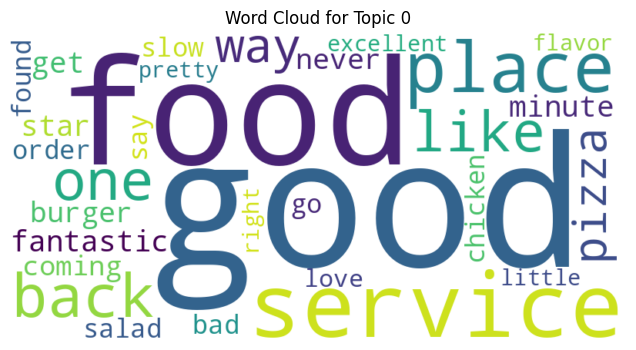

In [25]:
# Word Cloud
from wordcloud import WordCloud
topic_id = 0  # change to 1,2,3,... to see other topics
topic_terms = lda_model.show_topic(topic_id, topn=30)

# Build a frequency dict: {word: weight}
freq_dict = {word: weight for word, weight in topic_terms}

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud = wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Word Cloud for Topic {topic_id}")
plt.show()

In [26]:
# Summary
# Crosstab: for each topic, what % of reviews are pos/neu/neg?
sentiment_by_topic = pd.crosstab(
    df['dominant_topic'],
    df['sentiment'],
    normalize='index'
) * 100

print("Sentiment by topic (% of reviews within each topic):")
print(sentiment_by_topic.round(2))

Sentiment by topic (% of reviews within each topic):
sentiment       negative  neutral  positive
dominant_topic                             
0                  25.51    22.45     52.04
1                  19.39    22.43     58.17
2                  27.46    19.72     52.82
3                  29.46    30.80     39.73
4                  25.14    25.71     49.14


### ✍️ Your Response: 🔧
List your topics and names here:
Topic 0 : Food Quality
Topic 1 : Staff Service
Topic 2 : Price and Value
Topic 3 : Ambiance and Cleanliness
Topic 4 : Wait time and Crowds

## 8. Reflect and Recommend

**Business framing:**  
Ultimately, the value of your model comes from how well it can guide business decisions. Use your results to make real-world recommendations.

### In Your Response:
1. What business question did your model help answer?
2. What would you recommend to this restaurant to improve customer satisfaction?
3. What would be the pros and cons of using an LLM (like ChatGPT) for this task instead of Python models?
4. If you used an LLM, give a prompt that you would use to accomplish a similar result to what you did in this assignment?  (remember to set the context, specify the output and explain the objectives)


### ✍️ Your Response: 🔧
1. My model helped answer the core business question: “What exactly are customers talking about in their reviews, and which aspects of the restaurant are making them happy or unhappy?”

2. Based on those results, I would recommend that the restaurant prioritize fixing the topics with the highest percentage of negative sentiment. If, for example, the “Slow Service” or “Rude Staff” topic shows many negative reviews, management should focus on staff training, clearer staffing levels during peak hours, and better table/waitlist management.

3. Using an LLM like ChatGPT instead of Python models would have some clear pros and cons.
Pros:
Much less setup: no need to install libraries, clean text manually, or configure LDA/VADER.

LLMs can understand context, sarcasm, and nuanced language better than simple rule-based sentiment and bag-of-words topics.
Cons:
Less transparent and reproducible: it's harder to see exact token weights or topic probabilities, and different calls may give slightly different answers.

Data privacy and cost concerns if you're sending real customer data to an external API.

4. If I used an LLM to achieve something similar to this assignment, I might use a prompt like this:

System / Context:
You are a data analyst helping a restaurant owner understand customer reviews. You will read a set of restaurant reviews and analyze them for sentiment (positive/neutral/negative) and key topics (e.g., food quality, service, price, ambiance, etc.).

## Submission Instructions
✅ Checklist:
- All code cells run without error
- All markdown responses are complete
- Submit on Canvas as instructed

In [ ]:
!jupyter nbconvert --to html "assignment_11_LastnameFirstname.ipynb"